In [13]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode, tools_condition

load_dotenv()
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [17]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 102.4,
        "GOOG": 125.4,
        "IBM": 105.3,
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")

llm_with_tools = llm.bind_tools(tools)

In [21]:
def chatbot(state: State) -> State:
    print("📥 Incoming state keys:", state.keys())
    print("🧾 Messages before invoke:", state["messages"])

    result = llm_with_tools.invoke(state["messages"])

    print("🧠 Model output:", result)
    return {"messages": state["messages"] + [result]}


builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode([get_stock_price]))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")  # returns control after tool execution
builder.add_edge("chatbot", END)


graph = builder.compile(checkpointer=memory)

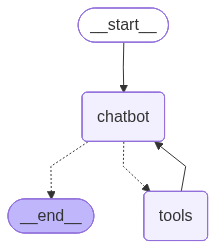

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from typing import Annotated, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# --- Define State ---
class State(TypedDict):
    messages: Annotated[list, add_messages]

# --- Tool ---
@tool
def get_stock_price(symbol: str) -> float:
    """Return stock price"""
    return {
        "MSFT": 200.3,
        "AAPL": 102.4,
        "GOOG": 125.4,
        "IBM": 105.3,
    }.get(symbol.upper(), 0)

# --- LLM ---
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools([get_stock_price])

# --- Node ---
def chatbot(state: State) -> State:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}

# --- Graph ---
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode([get_stock_price]))
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer=memory)

# --- Run ---
state = graph.invoke({
    "messages": [HumanMessage(content="What is the price of AAPL stock right now?")]
})

# msg = "I want to buy 20 AAPL stocks using current price. Then 15 MSFT. what will be total cost?"

# state = graph.invoke({
#     "messages": [HumanMessage(content=msg)]
# })
print(state["messages"][-1].content)


ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [20]:
msg = "I want to buy 20 AAPL stocks using current price. Then 15 MSFT. what will be total cost?"

state = graph.invoke({
    "messages": [HumanMessage(content=msg)]
})
print(state["messages"][-1].content)

📥 Incoming state keys: dict_keys(['messages'])
🧾 Messages before invoke: [HumanMessage(content='I want to buy 20 AAPL stocks using current price. Then 15 MSFT. what will be total cost?', additional_kwargs={}, response_metadata={}, id='1355ed31-94d0-4391-ae91-b85ff586881a')]
🧠 Model output: content='' additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--cb6a6065-8f3d-4018-9c8c-739516db77cb-0' tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AAPL'}, 'id': '46e3a739-2ddf-466d-adab-c13a3329de5a', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 'cda9c39e-e657-40fe-aa79-189960051480', 'type': 'tool_call'}] usage_metadata={'input_tokens': 63, 'output_tokens': 16, 'total_

In [23]:
config = { 'configurable': { 'thread_id': '1'}}
msg = "I want to buy 20 AAPL stocks using current price. Then 15 MSFT. what will be total cost?"

state = graph.invoke({
    "messages": [HumanMessage(content=msg)]
}, config=config)
print(state["messages"][-1].content)

📥 Incoming state keys: dict_keys(['messages'])
🧾 Messages before invoke: [HumanMessage(content='I want to buy 20 AAPL stocks using current price. Then 15 MSFT. what will be total cost?', additional_kwargs={}, response_metadata={}, id='8b37765d-4d23-4488-a3d1-ab5154946a64')]
🧠 Model output: content='' additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--847ec767-028a-4a9e-9a14-fee0c2ba78fb-0' tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AAPL'}, 'id': '563da35f-5cb9-4d82-a95b-c53fad67d0ae', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 'f44bfac7-82e3-4539-b453-bf668199c123', 'type': 'tool_call'}] usage_metadata={'input_tokens': 63, 'output_tokens': 16, 'total_

In [24]:
msg = "Using the current price tell me the total price of 10 GOOG stocks and add it to previous total"

state = graph.invoke({
    "messages": [HumanMessage(content=msg)]
}, config=config)
print(state["messages"][-1].content)

📥 Incoming state keys: dict_keys(['messages'])
🧾 Messages before invoke: [HumanMessage(content='I want to buy 20 AAPL stocks using current price. Then 15 MSFT. what will be total cost?', additional_kwargs={}, response_metadata={}, id='8b37765d-4d23-4488-a3d1-ab5154946a64'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--847ec767-028a-4a9e-9a14-fee0c2ba78fb-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AAPL'}, 'id': '563da35f-5cb9-4d82-a95b-c53fad67d0ae', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 'f44bfac7-82e3-4539-b453-bf668199c123', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 16, 'total_t